# Language Modeling With PyTorch

## Part 1

## Table of Contents
- [Introduction](#Introduction)
- [References](#References)
- [Inspecting the data](#Inspecting-the-data)
- [Bigram language model](#Bigram-language-model)
  - [Evaluating the quality of the model](#Evaluating-the-quality-of-the-model)
- [A neural network approach](#A-neural-network-approach)
  - [The training set](#The-training-set)
  - [Feeding the network](#Feeding-the-network)
  - [Regaining a normal distribution](#Regaining-a-normal-distribution)
  - [Recap: How the Neural Network Processes Input Characters](#Recap:-How-the-Neural-Network-Processes-Input-Characters)
  - [Optimization](#Optimization)
  - [Putting it all together](#Putting-it-all-together)
    - [Preparing data](#Preparing-data)
    - [Initializing the neural network](#Initializing-the-neural-network)
    - [Training the neural network](#Training-the-neural-network)
    - [Comparison with a Bigram frequency model](#Comparison-with-a-Bigram-frequency-model)
    - [Smoothing applied to a neural network](#Smoothing-applied-to-a-neural-network)
    - [Sampling from our trained model](#Sampling-from-our-trained-model)
  - [Conclusion](#Conclusion)
- [Exercises](#Exercises)
  - [1. Build a Trigram model](#1.-Build-a-Trigram-model)
  - [2. Split the dataset](#2.-Split-the-dataset)
    - [Bigram model baseline](#Bigram-model-baseline)
    - [Compare the Bigram and Trigram model](#Compare-the-Bigram-and-Trigram-model)
  - [3. Change the loss function](#3.-Change-the-loss-function)

## Introduction

The purpose of this multi-part notebook is to give a gentle introduction to the PyTorch library, with a focus on language modeling.
At high-level, we will build a progressively more complex **character-level language model** that can generate more text similar to the training data.

The final result is not meant to be a "production-ready" language model, but rather a simple yet effective example of how to use PyTorch for language modeling.
Along the way, we will learn the fundamental building blocks that lay the groundwork for more complex models, including the base models that power the state-of-the-art LLMs and derived products, like our friendly and always helpful assistant ChatGPT.

The final implementation will allow you to experiment with different models, starting from the most simple and basic one (a **bigram** model, where one character predicts the next one with a lookup table of counts) to a more complex **RNN** and finally a **Transformer** model.


## References

Some literature references about the concepts touched by one or more parts of this tutorial: 

- Multi-Layer Perceptron (MLP): [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- Convolutional Neural Network (CNN): [DeepMind WaveNet 2016](https://arxiv.org/abs/1609.03499)
- Recurrent Neural Network (RNN): [Mikolov et al. 2010](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf)
- Long Short-Term Memory (LSTM): [Graves et al. 2014](https://arxiv.org/abs/1308.0850)
- Gated Recurrent Unit (GRU): [Kyunghyun Cho et al. 2014](https://arxiv.org/abs/1409.1259)
- Transformer: [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762)

A few more related resource (hands-on, tutorial, articles, videos, etc.):
- Book "[Build a Large Language Model (From Scratch)](http://mng.bz/orYv)" by Sebastian Raschka (the companion [GitHub repository](https://github.com/rasbt/LLMs-from-scratch))
- [Andrej Karpathy's "Neural Net: From Zero to Hero"](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ) (*This was the **main** inspiration for this and the subsequent notebooks*)
- A [tutorial](https://docs.fast.ai/tutorial.text.html) on *transfer learning* by fastai
- [Hugging Face's FineWeb dataset](https://huggingface.co/spaces/HuggingFaceFW/blogpost-fineweb-v1)
- [Transformer LLM 3D visualizer](https://bbycroft.net/llm)

## Inspecting the data

In [7]:
import pathlib as pl

Our initial dataset is a simple list of strings that represent common names:

In [8]:
words = pl.Path("data/lm/names.txt").read_text().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [9]:
len(words), min(len(w) for w in words), max(len(w) for w in words)

(32033, 2, 15)

The information we can extract from a single name, e.g. `isabella`, is multiple:

- We know that the character `i` is followed by `s`.
- We know that, after the characters `isabell`, the following character is `a`.
- We know that, after the characters `isabella`, the following character is `\n` (end of string).

The idea is that a single word packs multiple pieces of information regarding the statistical structure of the language it belongs to.
And since we have about 32k words, there's quite a lot of information we can use to train even a simple language model.

## Bigram language model

A bigram language model is the simplest possible language model.
Given a sequence of characters (each character is usually referred to as a **token**), the bigram language model assigns a probability to each possible next token, given the previous token.
It's a predictor for each pair of tokens.

In [10]:
for w in words[:3]:
    for ch1, ch2 in zip(w, w[1:]):
        print(ch1, ch2)

e m
m m
m a
o l
l i
i v
v i
i a
a v
v a


The most basic modeling of the statistical patterns embedded in our input data is predicting the next token **by frequency**.
We can build a simple dictionary that counts how many times a bigram (i.e., sequence of two tokens) appear in our dataset.

We also need to add the *special* information about the start and end of the sequence.
We can "encode" that information with two **special tokens**: `<S>` (start) and `<E>` (end)

In [13]:
from collections import defaultdict

bigrams = defaultdict(int)

for w in words:
    chars = ["<S>"] + list(w) + ["<E>"]
    for ch1, ch2 in zip(chars, chars[1:]):
        bigrams[(ch1, ch2)] += 1

print(dict(bigrams))

{('<S>', 'e'): 1531, ('e', 'm'): 769, ('m', 'm'): 168, ('m', 'a'): 2590, ('a', '<E>'): 6640, ('<S>', 'o'): 394, ('o', 'l'): 619, ('l', 'i'): 2480, ('i', 'v'): 269, ('v', 'i'): 911, ('i', 'a'): 2445, ('<S>', 'a'): 4410, ('a', 'v'): 834, ('v', 'a'): 642, ('<S>', 'i'): 591, ('i', 's'): 1316, ('s', 'a'): 1201, ('a', 'b'): 541, ('b', 'e'): 655, ('e', 'l'): 3248, ('l', 'l'): 1345, ('l', 'a'): 2623, ('<S>', 's'): 2055, ('s', 'o'): 531, ('o', 'p'): 95, ('p', 'h'): 204, ('h', 'i'): 729, ('<S>', 'c'): 1542, ('c', 'h'): 664, ('h', 'a'): 2244, ('a', 'r'): 3264, ('r', 'l'): 413, ('l', 'o'): 692, ('o', 't'): 118, ('t', 't'): 374, ('t', 'e'): 716, ('e', '<E>'): 3983, ('<S>', 'm'): 2538, ('m', 'i'): 1256, ('a', 'm'): 1634, ('m', 'e'): 818, ('<S>', 'h'): 874, ('r', 'p'): 14, ('p', 'e'): 197, ('e', 'r'): 1958, ('r', '<E>'): 1377, ('e', 'v'): 463, ('v', 'e'): 568, ('l', 'y'): 1588, ('y', 'n'): 1826, ('n', '<E>'): 6763, ('b', 'i'): 217, ('i', 'g'): 428, ('g', 'a'): 330, ('a', 'i'): 1650, ('i', 'l'): 1345,

What does an entry of the bigram dictionary look like?
It's something like `('a', '<E>'): 6640`, which means: the bigram `('a', '<E>')` occurred 6640 times.
That is: the letter `a` is quite likely to appear at the end of a name.

We want to sort the bigrams by their count, from the most frequent to the least frequent.
Let's see the first 10 most frequent bigrams:

In [182]:
sorted(bigrams.items(), key=lambda x: x[1], reverse=True)[:20]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422)]

A much better way to store this information in a 2D array, where the rows are going to be the 1st character and the columns are going to be the 2nd character.
The entry at row `a` and column `b` is going to be the count of the bigram `ab`.

Since we are dealing with 26 characters, plus `<S>` and `<E>`, we need a total of 28x28 = 784 entries.
Bracketed tokens are customary in NLP to represent special tokens, but here we are only interested in knowing when a sentence starts or ends.

But there's also a problem with keeping two special tokens for the start and end of a sentence: we can't have `('<S>', '<S>')` or `('<E>', '<E>')`, or other combinations like `('a', '<S>')` or `('<E>', 'b')`.
These would be invalid bigrams.
To solve this, we can replace `<S>` with `.` and `<E>` with `.` and have a total of 27x27 = 729 entries.

In [43]:
import torch

N = torch.zeros((27, 27), dtype=torch.int32)

How should we encode the bigrams?
Our 2D array is going to hold integers **only**, so we need a way to make this conversion.
One way is to be a so-called **vocabulary** from our input data.

A vocabulary requires two functions:
1. `stoi`: string to integer (**encoding**)
2. `itos`: integer to string (**decoding**)

In [44]:
chars = sorted(set(''.join(words)))
print(chars)
print('')

stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0 # special token for end of sentence is mapped to 0
itos = {i:s for s, i in stoi.items()}

print(stoi)
print('')
print(itos)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [45]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        i = stoi[ch1]
        j = stoi[ch2]
        N[i, j] += 1
print(N)

tensor([[   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929],
        [6640,  556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568,
         2528, 1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,
          182, 2050,  435],
        [ 114,  321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,
          103,    0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,
            0,   83,    0],
        [  97,  815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,
          116,    0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,
            3,  104,    4],
        [ 516, 1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,
           60,   30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,
            0,  317,    1],
        [3983,  679,  121,  153,  384, 1271,   82,

Let's create a nice visualization of our bigram frequency table:

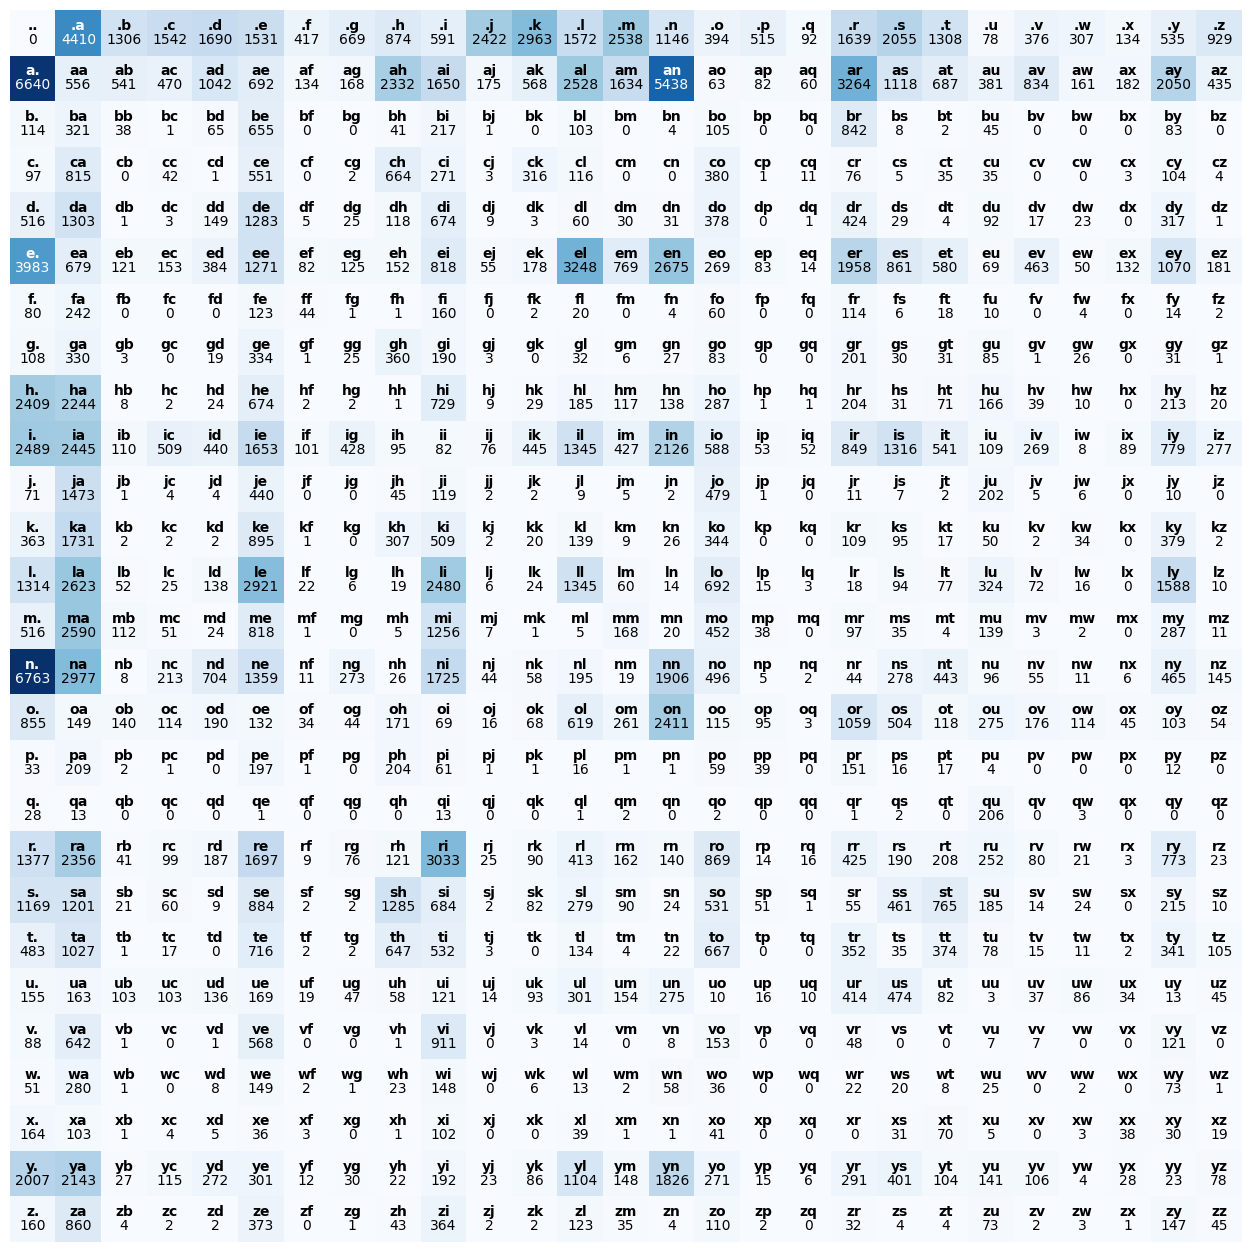

In [46]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,16))
norm = mpl.colors.Normalize(vmin=N.min(), vmax=N.max())
im = ax.imshow(N, cmap='Blues')

for i in range(N.shape[0]):
    for j in range(N.shape[1]):
        val = norm(N[i,j])
        text_color = 'white' if val > 0.5 else 'black'
        # character
        ax.text(j, i, itos[i]+itos[j],
                ha="center", va="bottom",
                color=text_color, fontweight='bold')
        # count
        ax.text(j, i, int(N[i,j]),
                ha="center", va="top",
                color=text_color)

ax.set_axis_off()

Our bigram model is essentially an iterative sampling from a probability distribution that describes how frequent each bigram is in the dataset.

We already have the frequency table, so we need to built a probability distribution and a sampling mechanism.
Let's do it for the first row, which represents the frequency of each bigram starting with the character '.'

In [49]:
proba = N[0].float()
print(proba)
print('')
proba /= proba.sum()
print(proba)

tensor([   0., 4410., 1306., 1542., 1690., 1531.,  417.,  669.,  874.,  591.,
        2422., 2963., 1572., 2538., 1146.,  394.,  515.,   92., 1639., 2055.,
        1308.,   78.,  376.,  307.,  134.,  535.,  929.])

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])


PyTorch provides us with a method to sample from a [**Multinomial distribution**](https://docs.pytorch.org/docs/main/distributions.html#multinomial).
A Multinomial distribution is a generalization of a [**Binomial distribution**](https://en.wikipedia.org/wiki/Binomial_distribution), where we sample from a distribution with more than two outcomes.

To enforce predictability, we can initialize a random number generator with a fixed seed.
Also, we need to allow sampling **with replacement**, so that we can sample the same token multiple times.

In [50]:
gen = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(proba, num_samples=1, replacement=True, generator=gen).item()
print(itos[ix])

c


We can of course sample as many tokens as we want:

In [51]:
torch.multinomial(proba, num_samples=100, replacement=True, generator=gen)

tensor([ 9, 18,  2,  5,  3,  1, 13, 11, 11, 22, 11, 15, 26,  2, 18, 13, 10,  1,
        15,  2,  3, 15, 10, 12,  4,  9,  3,  4,  6,  4, 19, 10,  3,  8,  4, 10,
        13, 14, 13, 10, 19, 11,  8, 13,  5,  5,  6, 25, 20, 10, 18,  1,  8,  3,
         2, 20,  1,  1,  3, 10, 11, 25, 18,  1,  9, 11,  8, 12,  3, 12, 19,  9,
        18, 13,  4,  4, 13, 13,  8, 13,  1,  2,  4,  1,  6,  1,  1, 10, 14, 10,
        13, 12, 10,  1,  1, 20, 18, 20, 19,  1])

You might have understood how the process goes: after we extract a given bigram, we need to lookup the most likely bigram that starts with the second character of the first bigram.

In [58]:
g = torch.Generator().manual_seed(2147483647)
NUM_WORDS = 20

for _ in range(NUM_WORDS):
    
    out = []
    ix = 0
    
    while True:
        # Compute the probabilities
        p = N[ix].float()
        p /= p.sum()
    
        # Sample the next character
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    
        # Stop if we reach the end of the text
        if ix == 0:
          break
        else:
            # Add the character to the output
            out.append(itos[ix])

    print(''.join(out))

cexze
momasurailezitynn
konimittain
llayn
ka
da
staiyaubrtthrigotai
moliellavo
ke
teda
ka
emimmsade
enkaviyny
ftlspihinivenvorhlasu
dsor
br
jol
pen
aisan
ja


The results are quite terrible, although they're reasonable given the simplicity of the model and the patterns we're trying to capture.

The core problem is that a bigram model looks only at the frequency of a pair of tokens, but it has zero information of what's most likely to come before or after those two tokens.
You can imagine that the obvious next step is a **trigram** model, which looks at the frequency of a triplet of tokens.

Let's now improve a bit our code: the first thing is to compute **all** the probabilities once, and then sample from them.
PyTorch tensors support **vectorized** operations, which means that we can perform operations on entire tensors at once, without having to loop through them.

Each row of our 2D matrix contains the counts of how many times the token with that row index is followed by all the other tokens, whose indexes run along the columns.

$$
P_{ij}= \frac{N_{ij}}{\displaystyle\sum_{k} N_{i k}}
$$

For each pair $(i,j)$:
- The numerator $N_{ij}$ is the count of the number of times token `j` follows token `i`.
- The denominator $\sum_{k} N_{i k}$ is the total number of times *any* character follows `i`.

In Python

```python
P = N.float()
P /= P.sum(dim=1, keepdim=True)
```

Here `dim=1` tells PyTorch to sum over the columns (the second index), while `keepdim=True` tells it to keep the first dimension (the first index) as a singleton (a `1`) dimension.
Without `keepdim=True`, the result would have shape `(27,)`, and performing the division would produce the wrong result because of how [brodcasting](https://pytorch.org/docs/stable/notes/broadcasting.html) works.

> Try to experiment with the `keepdim` parameter and see what happens if you remove it.
> Can you explain why the predictions become complete garbage?

In [61]:
g = torch.Generator().manual_seed(2147483647)

P = N.float()
P /= P.sum(dim=1, keepdim=True)

for _ in range(10):
  
  out = []
  ix = 0

  while True:
    # Get the probabilities
    p = P[ix]
    
    # Sample the next character
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    
    # Add the character to the output
    out.append(itos[ix])
    
    # Stop if we reach the end of the text
    if ix == 0:
      break

  print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.


### Evaluating the quality of the model

We have built a bigram language model by counting letter combination frequencies, then normalizing and sampling with that probability base.

We trained the model, we sampled from the model (iteratively, character-wise).
But its still bad at coming up with names.

But how bad?
We know that the model's "knowledge" is represented by `P`, but how can we boil down the model's quality in one value?

First, let's look at the bigrams we created from the dataset: the bigrams to `emma` are `.e, em, mm, ma, a.`.
**What probability does the model assign to each of those bigrams?**

In [62]:
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]): # Neat way for two char 'sliding-window'
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        print(f'{ch1}{ch2}: {prob:.2%}')

.e: 4.78%
em: 3.77%
mm: 2.53%
ma: 38.99%
a.: 19.60%


Anything above or below $\frac{1}{27} \approx 3.7\%$ means we deviate from the mean, that is, a completely uniform distribution of bigrams. 
And that means we learned something from the bigram statistics.

How can we summarize these probabilities into a quality indicating measurement?
We may compute the product of all probabilities — a number called the **likelihood**.
But since all these probabilities are small numbers, the product is also a small number, and it is hard to compare likelihoods.
Solution: *The log-likelihood, the **sum** of $\log(P)$ over all the individual token probabilities* ($\log$ is applied for convenience).

> The higher the log-likelihood, the better the model, because the more capable it is of predicting the next character in a sequence from the dataset.

In [67]:
# Initialize variables
log_likelihood = 0.0
n = 0  # character pair count IN DATASET

for word in words:
    # Add start/end tokens and convert to character list
    chars = ['.'] + list(word) + ['.']
    
    # Calculate log probabilities in a more compact way
    for ch1, ch2 in zip(chars, chars[1:]):
        prob = P[stoi[ch1], stoi[ch2]]
        log_likelihood += torch.log(prob)
        n += 1

print(f'{log_likelihood=}')

nll = -log_likelihood

print(f'{nll=}')  # Negative log likelihood
print(f'Average NLL: {nll/n:.4f}')  # More descriptive output

log_likelihood=tensor(-559891.7500)
nll=tensor(559891.7500)
Average NLL: 2.4541


We calculated a negative log-likelihood, because this follows the convention of setting the goal to minimize the **loss function**, the function that drives the optimization (i.e., training) process.
The lower the loss/negative log-likelihood, the better the model.

We got $2.45$ for the model.
The lower, the better.
We need to find the parameters that reduce this value.

**Goal:** Maximize likelihood of the trained data w. r. t. model parameters in `P`
- This is equivalent to maximizing the log-likelihood (as $\log$ is monotonic)
- This is equivalent to minimizing the *negative* log-likelihood
- And this is equivalent to minimizing the average negative log-likelihood (the quality-measurement, as shown by $2.45$ above)

There's an immediate problem, though: if we have a word containing a bigram that **never** appears in our training data, the model will assign a probability of $0$ to it, which will make the log-likelihood $-\infty$.

In [68]:
# Initialize variables
log_likelihood = 0.0
n = 0  # character pair count

for word in ["edobq"]:
    # Add start/end tokens and convert to character list
    chars = ['.'] + list(word) + ['.']
    
    # Calculate log probabilities in a more compact way
    for ch1, ch2 in zip(chars, chars[1:]):
        prob = P[stoi[ch1], stoi[ch2]]
        log_likelihood += torch.log(prob)
        n += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')  # Negative log likelihood
print(f'Average NLL: {nll/n:.4f}')  # More descriptive output

log_likelihood=tensor(-inf)
nll=tensor(inf)
Average NLL: inf


A negative infinite log-likelihood is definitely not good because our optimizer will never find a "stable" solution.

One simple fix is to assign a small but non-zero probability to every bigram: this is called **model smoothing**.
The easiest way is to ensure that no bigram *never* appears: we can achieve this by adding a constant to our 2D matrix `N`.

In [74]:
S = 1
PS = (N + S).float()  # The higher the number, the more smoothing we apply
PS /= PS.sum(dim=1, keepdim=True)

# Initialize variables
log_likelihood = 0.0
n = 0  # character pair count

for word in ["edobq"]:
    # Add start/end tokens and convert to character list
    chars = ['.'] + list(word) + ['.']
    
    # Calculate log probabilities in a more compact way
    for ch1, ch2 in zip(chars, chars[1:]):
        prob = PS[stoi[ch1], stoi[ch2]]  # Use the smoothed probabilities
        log_likelihood += torch.log(prob)
        n += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')  # Negative log likelihood
print(f'Average NLL with {S:.4f} smoothing: {nll/n:.4f}')  # More descriptive output

log_likelihood=tensor(-23.9499)
nll=tensor(23.9499)
Average NLL with 1.0000 smoothing: 3.9917


In [75]:
# apply smoothing
S = 1
PS = (N + S).float()
PS /= PS.sum(dim=1, keepdim=True)

# Initialize variables
log_likelihood = 0.0
n = 0  # character pair count IN DATASET

for word in words:
    # Add start/end tokens and convert to character list
    chars = ['.'] + list(word) + ['.']
    
    # Calculate log probabilities in a more compact way
    for ch1, ch2 in zip(chars, chars[1:]):
        prob = PS[stoi[ch1], stoi[ch2]]
        log_likelihood += torch.log(prob)
        n += 1

print(f'{log_likelihood=}')

nll = -log_likelihood

print(f'{nll=}')  # Negative log likelihood
print(f'Average NLL with {S:.4f} smoothing: {nll/n:.4f}')  # More descriptive output

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
Average NLL with 1.0000 smoothing: 2.4544


## A neural network approach

We will cast the problem of character estimation into the framework of neural networks.
The problem remains the same, the approach changes, and the outcome should look similar.

Our neural network **receives a single character** and **outputs the probability distribution over the next possible characters** ($27$ in this case).

It's going to make guesses on the most likely character to follow.
We can still measure the performance through the *same* loss function, the negative log-likelihood.

From the training data, we also know the character that actually comes next in each training example.
We'll use this information to fine-tune (i.e., train or update the parameters of) the neural network to make better guesses: this is a textbook example of **supervised learning**.

### The training set

In [132]:
import torch

In [229]:
# Create training set of all bigrams
xs, ys = [], [] # Input and output character indices

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

# Convert lists to tensors
xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs, ys)

tensor([ 0,  5, 13,  ..., 25, 26, 24]) tensor([ 5, 13, 13,  ..., 26, 24,  0])


We can inspect the first few tokens from the two tensors:
- `xs` will be the input tokens (what the model will see)
- `ys` will be the target tokens (what we want the model to predict)

In [134]:
for i in range(5):
    print(f'For character #{i} "{itos[xs[i].item()]}" in xs, we expect the model to predict "{itos[ys[i].item()]}"')

For character #0 "." in xs, we expect the model to predict "e"
For character #1 "e" in xs, we expect the model to predict "m"
For character #2 "m" in xs, we expect the model to predict "m"
For character #3 "m" in xs, we expect the model to predict "a"
For character #4 "a" in xs, we expect the model to predict "."


One important detail about PyTorch tensors: there exists `torch.Tensor` (a class) and `torch.tensor()` (a method).
They are related, but different:
- `torch.Tensor` is a class, and every PyTorch tensor is an instance of this class.
- `torch.tensor()` is a method to create a tensor, with `dtype` automatically inferred from the input data.

Except for when initializing a completely empty tensor, in general there is no reason to choose `torch.Tensor` over `torch.tensor`. 
Note that `torch.Tensor` is an alias for `torch.FloatTensor`, with a default `dtype` of `torch.float32`.

In general, you should use `torch.tensor()` almost always, unless you have a specific reason to use `torch.Tensor`.

Here you can find more details from the official docs:
- [`torch.tensor()`](https://docs.pytorch.org/docs/stable/generated/torch.tensor.html#torch-tensor)
- [`torch.Tensor`](https://docs.pytorch.org/docs/stable/tensors.html)

In [135]:
xs.dtype, xs.type()

(torch.int64, 'torch.LongTensor')

`torch.LongTensor` here means that the tensor contains 64-bit (8-byte) integers.

### Feeding the network

A neural network essentially is made up of **layers**.
At high-level, each layer is typically a linear transformation followed by a non-linear activation function.
Something like: $\text{output} = \text{activation}(\text{weights} \cdot \text{input} + \text{bias})$

If we were to feed our characters as integer indexes, we would have a sequence of integer indexes as input.
If `a` is 1 and `z` is 25, the weight applied to `z` will have 25 times more impact on the output than `a`.
This creates an arbitrary and misleading mathematical relationship.

Moreover, during the training (optimization) phase, the updates to the weights will be proportional to their input values.
Larger input values will cause larger updates to the weights, which can lead to unstable training.

And lastly, the network has no reference to the potential value range.
It doesn't know that the values are constrained to a specific set (like 0-25 for letters).

To address all these issues, we can use **one-hot encoding**.
One-hot encoding each letter means creating a vector where only one position has a value of 1 (corresponding to that letter's position in the alphabet) and all other positions are 0.
This gives the neural network a much clearer signal about which letter is present without introducing misleading numerical relationships.
This approach is particularly important in language models where the relationships between symbols (letters, words) are learned from their contexts and co-occurrences, not from arbitrary numeric values assigned to them.

Luckily, PyTorch provides a convenient way to perform one-hot encoding using the `torch.nn.functional.one_hot` function.

Let's encode the first 5 tokens (`.emma`), print and visualize the result:

In [230]:
import torch.nn.functional as F
F.one_hot(xs[:5], num_classes=27)
xenc = F.one_hot(xs[:5], num_classes=27)
xenc.shape

torch.Size([5, 27])

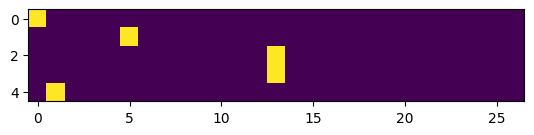

In [138]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(xenc)

One problem is the `dtype` of the one-hot encoded tensor.
It is `torch.int64` by default (inferred from our data), but we need `torch.float32` to have an input suitable for the mathematical operations the network will perform.

We can convert it using `.float()`:

In [139]:
xenc = F.one_hot(xs[:5], num_classes=27).float()
xenc.dtype

torch.float32

Let's experiment with neurons.
We build one $27$-dimensional neuron and approach it with the letter-wise input of our first name `.emma` (That's $5$ letters)

A neuron is represented as a column vector of $27$ numbers, randomly drawn from a normal distribution.
We can do this with [`torch.randn`](https://docs.pytorch.org/docs/main/generated/torch.randn.html):

In [140]:
g = torch.Generator().manual_seed(2147483647)

W = torch.randn((27,1), generator=g)
# '@' is PyTorch's matrix multiplication operator (5x27 @ 27x1 -> 5x1)
a = xenc @ W

# This is now a 5x1 vector
print(a)

tensor([[ 1.5674],
        [-0.0296],
        [ 0.0380],
        [ 0.0380],
        [-0.2373]])


`W` is a **single** neuron.
Multiplying it by `xenc` makes it 'react' to the one-hot encoded input.
The result is a $5\times 1$ vector.

`.emma` has $5$ characters, we have $1$ neuron.
When this neuron processes the 5 characters of ".emma", it produces 5 activation values, one for each character.
Each activation value represents how strongly the neuron "reacts" to or "recognizes" each character.

We want to have $27$ neurons, one for each possible character.
Each neuron can "specialize" in recognizing one specific character.
Also, since each neuron has $27$ dimensions, we'll end up with a matrix $27\times 27$ of weights.

tensor([[-1.0549,  0.8372, -0.4971, -0.9398,  0.1343,  0.0540, -1.7400,  0.1156,
          0.2222,  1.0656, -0.0115,  0.4835, -0.3164,  0.3801,  0.4733, -0.9103,
          2.0275, -0.1158, -1.2078, -0.7441, -0.5903,  0.9374, -0.8830,  1.7457,
         -0.2838,  0.2569,  0.2130],
        [ 1.8598,  0.6098, -0.2536, -0.6392, -0.7340,  2.0002, -0.3946,  0.0144,
          0.5722, -0.6954, -0.3695, -1.2707, -0.7319, -0.2145,  0.3271,  1.9661,
         -0.2409, -0.2544, -0.1217, -0.7924,  0.9805,  0.4113,  1.2648,  1.4625,
          1.1199, -0.5960, -1.4941],
        [ 1.7206, -0.1636,  1.0800, -0.3147, -0.6407,  0.0451, -0.7922,  1.2307,
         -0.5276, -2.0498, -0.6486,  0.6921, -1.2772, -0.0102,  0.7459,  0.4899,
         -1.0034,  0.4609,  0.3420, -0.3521,  0.6725, -0.4441,  1.2331,  0.7748,
          0.2431,  0.8989, -0.7754],
        [ 1.7206, -0.1636,  1.0800, -0.3147, -0.6407,  0.0451, -0.7922,  1.2307,
         -0.5276, -2.0498, -0.6486,  0.6921, -1.2772, -0.0102,  0.7459,  0.4899

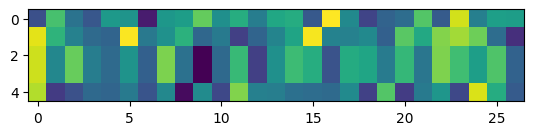

In [141]:
W = torch.randn((27,27), generator=g)
a = xenc @ W

# This is now a 5x27 matrix
print(a)
plt.imshow(a)

What the matrix multiplication did is give us the **firing rates** of each neuron for each character.
For example `(a @ W)[3, 13]` is the firing rate of the 14th neuron for the 4th character.
This is a very efficient way of computing the firing rates for all characters and all neurons.

In [142]:
xenc[3], W[:, 13]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([ 0.3801, -0.3056,  0.2072,  0.3175, -0.0558, -0.2145,  1.2348,  0.5205,
          0.8183, -0.6310, -1.4107,  0.6339, -0.0954, -0.0102,  0.0318,  0.1788,
         -0.2639,  0.2347,  0.5703, -2.3025, -1.8563,  1.3698, -0.3301,  1.2284,
         -0.7660,  0.1472, -0.5651]))

In [143]:
(xenc[3] * W[:, 13]).sum(), (xenc @ W)[3, 13]

(tensor(-0.0102), tensor(-0.0102))

### Regaining a normal distribution

We want the neurons per input (per character) to come up with a $27$-dimensional activation of values that could be transformed into a normal distribution on what character to choose next.
We've seen that with the Bigram's probability distribution, given info per character on what character is most likely to follow.

Right now, for every character we get $27$ numbers, positive and negative, but not following a normal distribution.

- **What we want:** For each character in our input, we want to predict the probability distribution of the next character (similar to a bigram model).

- **What we have:** For each character in our input, we get $27$ numbers, positive and negative, but not following a normal distribution.

- **Problem:** These raw outputs are just arbitrary numbers that can be positive or negative.
They don't naturally sum to 1 or represent probabilities.

The solution is to change our interpretation of the output values of the neurons.
We can think of the neural network's raw outputs as "log-counts" (also called "logits") or "scores" rather than direct probabilities.

To convert this numbers into proper probabilities:

1. First, we **exponentiate** each value (turning negative numbers into small positives and making large positives even larger)
2. Then, we normalize the values so that they sum to 1.

This is achievied with a function called **softmax** function.

torch.Size([5, 27])
tensor([1., 1., 1., 1., 1.])


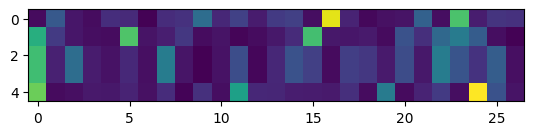

In [144]:
# Compute the raw output scores (logits) for each character in the input
logits = xenc @ W  # Shape: (5, 27) - 5 input characters, 27 possible output characters

# Exponentiate the logits to get positive "fake counts" (similar to unnormalized probabilities)
counts = logits.exp()  # Negative logits yield values between 0 and 1; positive logits yield values greater than 1; Shape: (5, 27)

# Normalize the counts along each row to obtain probabilities (each row sums to 1)
probs = counts / counts.sum(1, keepdims=True)  # Shape: (5, 27)
plt.imshow(probs)

# Print the shape of the probability matrix and verify normalization
print(probs.shape)      # Will print: (5, 27)
print(probs.sum(1))   # Will print: 1.0 (or very close, due to floating point precision)

It might seem unusual, but after this transformation, we have a set of numbers that we can use just like the actual counts from the bigram model.

All the values are non-negative: think of them as "pseudo-counts."
Now, our goal is simply to adjust the weights `W` so that the network produces the correct character indices as output.

### Recap: How the Neural Network Processes Input Characters

Given the input `.emma`, the neural network handles each character step by step:

1. **Input Preparation:**  
   - Take the current character (e.g., `.`) and map it to its index (e.g., 0).
   - One-hot encode this index into a 27-dimensional vector.

2. **Neural Network Computation:**  
   - Feed the one-hot vector into the network (shape: $27 \times 1$).
   - The network applies its weights, producing a $1 \times 27$ vector of activations (logits).

3. **Softmax Transformation:**  
   - Exponentiate each logit to ensure all values are positive.
   - Normalize the result so the values sum to 1, yielding a probability distribution over all possible next characters.

The Softmax function turns the network's raw outputs into probabilities, indicating how likely each character is to follow the current input.

The core question is now:  
Can we optimize the weights `W` so that the network’s predicted probabilities match the actual sequence in our data?

We can now evaluate how well our neural network predicts the next character in a sequence.
For each bigram (pair of consecutive characters), we:

- Feed the input character to the neural network.
- Get the predicted probability distribution for the next character.
- Check how much probability the network assigns to the actual next character.
- Calculate the negative log-likelihood (NLL) for this prediction, which tells us how "surprised" the network is by the true answer (lower is better).
- Finally, we average the NLLs across all bigrams to get the overall loss, which is what we want to minimize during training.

In [147]:
import numpy as np

# Reminder: xs is a tensor containing the indexes of **all** the characters
# We take the first 5 characters to form the bigrams
xs = xs[:5]
ys = ys[:5]

# Initialize tensor to store negative log likelihoods (NLL) for each bigram
nlls_old = torch.zeros(len(xs))  # There are 5 bigrams in '.emma.'

# Loop through each bigram in the sequence
for i in range(len(xs)):
    x = xs[i].item()  # Input character index
    y = ys[i].item()  # Target (next) character index

    print("\n-------")
    print(f'Bigram {i+1}: ("{itos[x]}", "{itos[y]}") [indexes ({x}, {y})]')
    print(f'  Input to neural net: {x} ("{itos[x]}")')
    print(f'  Output probabilities:\n{probs[i]}') # probabilities for the next character according to the single, randomly initialized neuron are saved in the vector 'probs' and called here
    
    # Most likely next character according to the model
    predicted_index = probs[i].argmax().item()
    predicted_char = itos[predicted_index]
    predicted_prob = probs[i].max().item()
    print(f'  Most likely next character: {predicted_char} (index {predicted_index}, probability {predicted_prob:.4f}, log likelihood {-np.log(predicted_prob):.4f})')
    
    print(f'  Actual next character (label): {itos[y]} (index {y})')
    
    # Probability assigned to the correct character
    p = probs[i, y]
    print(f'  Probability assigned to correct character: {p.item():.4f}')
    
    # Log likelihood and negative log likelihood (of correct character)
    logp = torch.log(p)
    nll = -logp
    print(f'  Log likelihood: {logp.item():.4f}')
    print(f'  Negative log likelihood: {nll.item():.4f}')
    
    # Store NLL for this bigram
    nlls_old[i] = nll

print('\n============')
print(f'Average negative log likelihood (loss): {nlls_old.mean().item():.4f}')


-------
Bigram 1: (".", "e") [indexes (0, 5)]
  Input to neural net: 0 (".")
  Output probabilities:
tensor([0.0087, 0.0579, 0.0152, 0.0098, 0.0287, 0.0264, 0.0044, 0.0281, 0.0313,
        0.0727, 0.0248, 0.0406, 0.0183, 0.0366, 0.0402, 0.0101, 0.1903, 0.0223,
        0.0075, 0.0119, 0.0139, 0.0640, 0.0104, 0.1436, 0.0189, 0.0324, 0.0310])
  Most likely next character: p (index 16, probability 0.1903, log likelihood 1.6591)
  Actual next character (label): e (index 5)
  Probability assigned to correct character: 0.0264
  Log likelihood: -3.6326
  Negative log likelihood: 3.6326

-------
Bigram 2: ("e", "m") [indexes (5, 13)]
  Input to neural net: 5 ("e")
  Output probabilities:
tensor([0.1260, 0.0361, 0.0152, 0.0104, 0.0094, 0.1450, 0.0132, 0.0199, 0.0348,
        0.0098, 0.0136, 0.0055, 0.0094, 0.0158, 0.0272, 0.1402, 0.0154, 0.0152,
        0.0174, 0.0089, 0.0523, 0.0296, 0.0695, 0.0847, 0.0601, 0.0108, 0.0044])
  Most likely next character: e (index 5, probability 0.1450, log like

What do these results tell us?
- In each case, the probability assigned to the correct next character is relatively low, meaning the model is not yet confident in its predictions.
- The most likely character predicted by the model is often not the correct one.
- The negative log likelihood values are relatively high, indicating the model is “surprised” by the true next character.
- The final line reports the average negative log likelihood (loss) across all bigrams: 3.44.
This is a key metric for training — the goal is to minimize this value by adjusting the model’s weights.

The network is currently not very accurate at predicting the next character, as shown by the low probabilities for the correct answers and the high loss.
This is expected at the start, before any training.

### Optimization

Remember that we started with `W` as a completely random matrix of floats.
Hoping that random initialization would yield a good solution is like hoping that a random collection of Lego bricks will build a house.

Instead, we will actively improve the model’s predictions.
Specifically, we will adjust the weights in the matrix `W` to increase the probability of correctly predicting the second character in each bigram.

This is done by computing how the loss changes with respect to each weight (i.e., calculating the gradients), and then updating the weights in a way to reduce the overall loss.
This process — called **gradient-based optimization** — enables the neural network to learn from its mistakes and become better at predicting the next character in the sequence.

In [148]:
# Display the probability assigned by the model to the correct next character for each bigram
bigram_descriptions = [
    ('input "." → output "e"', 0, 5),
    ('input "e" → output "m"', 1, 13),
    ('input "m" → output "m"', 2, 13),
    ('input "m" → output "a"', 3, 1),
    ('input "a" → output "."', 4, 0),
]

print("Probability assigned by the model to the correct next character for each bigram:\n")
for desc, i, j in bigram_descriptions:
    prob = probs[i, j].item()
    print(f"{desc:25s}: {prob:.4f}")

Probability assigned by the model to the correct next character for each bigram:

input "." → output "e"   : 0.0264
input "e" → output "m"   : 0.0158
input "m" → output "m"   : 0.0246
input "m" → output "a"   : 0.0211
input "a" → output "."   : 0.1548


We can extract pretty easily with PyTorch the probabilities the model assigns to the correct next character for each bigram:

In [149]:
probs[torch.arange(len(probs)), ys]

tensor([0.0264, 0.0158, 0.0246, 0.0211, 0.1548])

Our loss is, as before, the average negative log-likelihood from these values:

In [150]:
loss = -probs[torch.arange(len(probs)), ys].log().mean()
print(loss.item())

3.4416897296905518


The training phase has two main steps: the forward and the backward pass.

**Forward Pass**:
we feed input data through the network to obtain predictions (in this case, the probabilities for the next character).
We then compute a loss value, which measures how far off the network’s predictions are from the actual answers.
Here, the loss is the average negative log likelihood of the correct next character across all inputs.

**Backward Pass**:
The backward pass is where learning happens.
Using the computed loss, PyTorch automatically calculates how much each parameter (the weights in `W`) contributed to the error.
This is done via a process called **backpropagation**, which computes the gradients.
That is, it calculates the direction and amount by which each weight should be adjusted to reduce the loss.

We can instruct PyTorch to track all the operations we perform on tensors by setting `requires_grad=True`.
This is done by calling `W.requires_grad_(True)`.
This is a common pattern in PyTorch: we create a tensor, set `requires_grad=True`, and then perform operations on it.

So, in summary:

- Including the loss calculation in the forward pass gives us a measure of the network’s performance for each batch.
- Calling `.backward()` on the loss triggers PyTorch to compute gradients for all parameters with `requires_grad=True`.
- These gradients indicate how to adjust the weights to reduce the loss.
- Updating the weights using the gradients should improve the model’s predictions in the next iteration.

This is the core of the training loop.

### Putting it all together

Let's summarize all the steps and put it all together.

#### Preparing data

We break down text (a sequence of strings) into sequences of adjacent characters, called n-grams.
Here, we're creating "bigrams" (pairs of consecutive characters) from our dataset.

For each word in our input data:
1. We add special start and end markers (`.`)
2. We create pairs of adjacent characters
3. We convert each character to its numerical index using our mapping

This gives us input-output pairs `(x, y)` where:
- `x` is the index of the current character
- `y` is the index of the next character

These pairs become our training examples.

In [161]:
# Create training set of all bigrams from words
xs, ys = [], []

# Process each word to extract bigrams
for w in words:
    # Add start/end markers to each word
    chars = ['.'] + list(w) + ['.']
    
    # Create pairs of adjacent characters
    for ch1, ch2 in zip(chars, chars[1:]):
        # Convert characters to their indices
        idx1 = stoi[ch1]  # Current character index
        idx2 = stoi[ch2]  # Next character index
        
        # Add to our training examples
        xs.append(idx1)
        ys.append(idx2)

# Convert lists to PyTorch tensors
xs = torch.tensor(xs)
ys = torch.tensor(ys)

# Print dataset size
print(f'Number of training examples: {xs.nelement()}')

Number of training examples: 228146


#### Initializing the neural network

Our model is a simple, single-layer, no-bias neural network represented by a weight matrix `W`.

- The weight matrix has dimensions $27 \times 27$ (input size × output size)
- Each column represents the weights for predicting one of the 27 possible next characters
- We set `requires_grad=True` to enable automatic gradient computation during training (this is essential for backpropagation)

At this step, we can optionally tell PyTorch to use a GPU if available.

In [152]:
# Set the device (CPU or GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [153]:
# Initialize the neural network's weight matrix
g = torch.Generator(device=device).manual_seed(2147483647)  # Fixed seed for reproducibility

# Create weight matrix (27×27) with trainable parameters
W = torch.randn((27, 27), device=device, generator=g, requires_grad=True)

#### Training the neural network

We now train our model using gradient descent.
For each training epoch, we:

1. **Forward Pass:** Feed the input data through the network to get predictions
   - Convert inputs to one-hot encoding
   - Compute logits by matrix multiplication with weights
   - Apply softmax to get probability distributions
   - Calculate the loss (negative log likelihood)

2. **Backward Pass:** Compute gradients of the loss with respect to weights
   - Reset existing gradients
   - Backpropagate the loss

3. **Update Weights:** Adjust weights to reduce the loss
   - Simple gradient descent: `W = W - learning_rate * gradient`

The loss should decrease with each epoch, indicating the model is learning.

In [158]:
# Training for 200 epochs
for epoch in range(500):
    # ----- Forward Pass -----
    # Convert input indices to one-hot vectors
    xenc = F.one_hot(xs, num_classes=27).float().to(device)
    
    # Compute raw outputs (logits)
    logits = xenc @ W
    
    # Apply softmax: first exponentiate
    counts = logits.exp()
    
    # Then normalize to get probabilities
    probs = counts / counts.sum(1, keepdims=True)
    
    # Calculate negative log likelihood loss
    loss = -probs[torch.arange(len(probs)), ys].log().mean()
    
    # Print progress
    if (epoch + 1) % 25 == 0:
        print(f'Loss @ epoch {epoch+1}: {loss.item():.4f}')
    
    # ----- Backward Pass -----
    # Reset gradients
    W.grad = None
    
    # Compute gradients
    loss.backward()
    # calling the gradient on this loss value forces pytorch to calculate the change gradient of the loss on each parameter which requires it
    
    # ----- Update Weights -----
    if epoch <= 200:
        lr = 50
    else:
        lr = 10
    W.data -= lr * W.grad

Loss @ epoch 25: 2.1159
Loss @ epoch 50: 1.8892
Loss @ epoch 75: 2.1053
Loss @ epoch 100: 1.8992
Loss @ epoch 125: 2.0957
Loss @ epoch 150: 1.9083
Loss @ epoch 175: 2.0871
Loss @ epoch 200: 1.9165
Loss @ epoch 225: 0.2835
Loss @ epoch 250: 0.2803
Loss @ epoch 275: 0.2793
Loss @ epoch 300: 0.2788
Loss @ epoch 325: 0.2785
Loss @ epoch 350: 0.2783
Loss @ epoch 375: 0.2781
Loss @ epoch 400: 0.2780
Loss @ epoch 425: 0.2779
Loss @ epoch 450: 0.2779
Loss @ epoch 475: 0.2778
Loss @ epoch 500: 0.2778


#### Testing the trained neural network

In [165]:
# Reminder: xs is a tensor containing the indexes of **all** the characters
# We take the first 5 characters to form the bigrams
xt = xs[:5]
yt = ys[:5]

# Initialize tensor to store negative log likelihoods (NLL) for each bigram
nlls = torch.zeros(len(xs))  # There are 5 bigrams in '.emma.'

# Loop through each bigram in the sequence
for i in range(len(xt)):
    x = xt[i].item()  # Input character index
    y = yt[i].item()  # Target (next) character index

    print("\n-------")
    print(f'Bigram {i+1}: ("{itos[x]}", "{itos[y]}") [indexes ({x}, {y})]')
    print(f'  Input to neural net: {x} ("{itos[x]}")')
    print(f'  Output probabilities:\n{probs[i]}') # probabilities for the next character according to the single, randomly initialized neuron are saved in the vector 'probs' and called here
    
    # Most likely next character according to the model
    predicted_index = probs[i].argmax().item()
    predicted_char = itos[predicted_index]
    predicted_prob = probs[i].max().item()
    print(f'  Most likely next character: {predicted_char} (index {predicted_index}, probability {predicted_prob:.4f}, log likelihood {-np.log(predicted_prob):.4f})')
    
    print(f'  Actual next character (label): {itos[y]} (index {y})')
    
    # Probability assigned to the correct character
    p = probs[i, y]
    print(f'  Probability assigned to correct character: {p.item():.4f}')
    
    # Log likelihood and negative log likelihood (of correct character)
    logp = torch.log(p)
    nll = -logp
    print(f'  Log likelihood: {logp.item():.4f}')
    print(f'  Negative log likelihood: {nll.item():.4f}')
    
    # Store NLL for this bigram
    nlls[i] = nll

print('\n============')
print(f'Average negative log likelihood (loss): {nlls.mean().item():.4f}')
print(f'Old value: {nlls_old.mean().item():.4f}')


-------
Bigram 1: (".", "e") [indexes (0, 5)]
  Input to neural net: 0 (".")
  Output probabilities:
tensor([7.3536e-11, 9.8418e-10, 2.0232e-09, 2.0617e-09, 2.0603e-09, 1.0000e+00,
        1.1237e-09, 1.5416e-09, 1.7726e-09, 1.4296e-09, 1.8698e-09, 1.6319e-09,
        2.0629e-09, 1.8225e-09, 1.9616e-09, 1.0769e-09, 1.3060e-09, 3.0070e-10,
        2.0627e-09, 1.9949e-09, 2.0238e-09, 2.6250e-10, 1.0392e-09, 8.8534e-10,
        4.2889e-10, 1.3399e-09, 1.8206e-09], grad_fn=<SelectBackward0>)
  Most likely next character: e (index 5, probability 1.0000, log likelihood -0.0000)
  Actual next character (label): e (index 5)
  Probability assigned to correct character: 1.0000
  Log likelihood: 0.0000
  Negative log likelihood: -0.0000

-------
Bigram 2: ("e", "m") [indexes (5, 13)]
  Input to neural net: 5 ("e")
  Output probabilities:
tensor([4.5886e-10, 1.9874e-09, 6.0936e-10, 7.4726e-10, 1.4996e-09, 2.0841e-09,
        4.2863e-10, 6.2721e-10, 7.4244e-10, 2.0898e-09, 3.1381e-10, 8.4875e-10,


#### Comparison with a Bigram frequency model

Our trained neural network achieves a loss of around 2.46, which is nearly identical to the explicit bigram count approach (loss of 2.45).
This similarity isn't surprising—our simple neural network is essentially learning to mimic the count-to-distribution relationship of the bigram model.

**The key difference is in flexibility and scalability.**

The core workflow of the neural network will remain consistent as we build more complex models:

1. Initialize weights
2. Calculate activations 
3. Convert to probabilities
4. Optimize weights based on loss

While our current neural network doesn't outperform the simpler bigram approach, its architecture allows for natural extension to more complex patterns.
As we add layers and consider longer sequences of characters, the neural network framework will scale elegantly.

Consider the fundamental scaling challenge: with a bigram model looking at just the previous character, we need to store $27^2 = 729$ probabilities (one for each possible character pairs).
If we wanted to consider the previous 10 characters to make better predictions:

- A traditional n-gram approach would require storing $27^{10} \approx 205$ trillion different probability values—completely impractical in terms of memory and impossible to train with limited data.

- In contrast, a neural network can learn to **compress this information efficiently**.
By adding more neurons and layers, we can capture complex patterns without an exponential explosion in parameters.
A network might need only thousands or millions of parameters to effectively model these dependencies, not trillions.

This is why neural networks excel at language modeling tasks where context beyond just the previous character is crucial.

> **Conclusion:** 
>
>The bigram approach quickly hits scaling limitations, while neural networks excel precisely where the bigram model fails.

#### Smoothing applied to a neural network

Remember that with the Bigram Model we used a smoothing technique to avoid zero probabilities.
This was basically adding a small constant to all counts (`+1` in our case).
The bigger this constant, the more smoothed the distribution will be.

This is a simple example of a **regularization** technique, which can also be applied to our neural network approach.


How can we do this for a neural network?

1. We add a penalty term to the loss function based on the weights
2. This penalty pushes weights toward zero
3. Smaller weights result in smoother, more uniform output distributions
4. The strength of regularization is controlled by a tunable **hyperparameter**

> **Note:** an hyperparameter is a parameter that is not learned from the data, but is set by the user.

Think of regularization as a gentle force pulling weights toward zero.
Without it, the model might learn to perfectly match the training data but fail to generalize.
With regularization, we sacrifice some training accuracy for better generalization.

Here we will use **L2 regularization** (also called weight decay), which adds the mean of squared weights to the loss function.

In [166]:
# Calculate regularization term (mean of squared weights)
# This will be added to the loss function to penalize large weights
print("Regularization term (L2 norm of weights):")
reg_term = (W**2).mean().item()
print(f"{reg_term:.6f}")

Regularization term (L2 norm of weights):
4.136141


In [172]:
# Training for 200 epochs with regularization
lambda_reg = 0.01  # Regularization strength

for epoch in range(500):
    # ----- Forward Pass -----
    # Convert input indices to one-hot vectors
    xenc = F.one_hot(xs, num_classes=27).float().to(device)
    
    # Compute raw outputs (logits)
    logits = xenc @ W
    
    # Apply softmax: first exponentiate
    counts = logits.exp()
    
    # Then normalize to get probabilities
    probs = counts / counts.sum(1, keepdims=True)
    
    # Calculate negative log likelihood loss + regularization term
    # Main loss: how well we predict the next character
    nll_loss = -probs[torch.arange(len(probs)), ys].log().mean()
    # Regularization loss: penalty for large weights
    reg_loss = lambda_reg * (W**2).mean()
    # Combined loss
    loss = nll_loss + reg_loss

    if (epoch + 1) % 25 == 0:
        print(f'Loss @ epoch {epoch+1}: {loss.item():.4f}')
    
    # ----- Backward Pass -----
    # Reset gradients
    W.grad = None
    
    # Compute gradients (including regularization effect)
    loss.backward()
    
    # ----- Update Weights -----
    if epoch <= 200:
        lr = 200
    else:
        lr = 10
    W.data -= lr * W.grad

Loss @ epoch 25: 3.0922
Loss @ epoch 50: 2.9604
Loss @ epoch 75: 2.8735
Loss @ epoch 100: 2.6046
Loss @ epoch 125: 2.9479
Loss @ epoch 150: 2.7536
Loss @ epoch 175: 2.8286
Loss @ epoch 200: 2.8257
Loss @ epoch 225: 2.7206
Loss @ epoch 250: 2.5074
Loss @ epoch 275: 2.4808
Loss @ epoch 300: 2.4806
Loss @ epoch 325: 2.4805
Loss @ epoch 350: 2.4805
Loss @ epoch 375: 2.4804
Loss @ epoch 400: 2.4804
Loss @ epoch 425: 2.4804
Loss @ epoch 450: 2.4804
Loss @ epoch 475: 2.4804
Loss @ epoch 500: 2.4804


#### Sampling from our trained model

After training, we can use our model to generate new character sequences.

For each position:
1. We start with the "." character (index 0)
2. The model predicts probabilities for the next character
3. We sample from this probability distribution
4. We continue until we generate another "." (end marker)

This process is similar to what we did with the bigram model, but now using our neural network for predictions.

Incidentally, this is the same process that drives the generation of text by large language models like ChatGPT, although we are nowhere near the sophistication of ChatGPT.

In [176]:
# Sample new names from the trained model
# g = torch.Generator(device=device).manual_seed(2147483642)  # Fixed seed for reproducibility
g = torch.Generator(device=device).manual_seed(3107882632)

print("Generated names:")
for i in range(5):
    out = []
    ix = 0  # Start with '.' character (index 0)
    
    while True:
        # ----- Generate next character -----
        # Convert current character index to one-hot encoding
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float().to(device)
        
        # Forward pass through the model
        logits = xenc @ W  # Get logits (raw output scores)
        counts = logits.exp()  # Convert to positive values
        p = counts / counts.sum(1, keepdims=True)  # Normalize to probabilities
        
        # Sample from the probability distribution
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        
        # Stop when we generate an end marker
        if ix == 0:
            break
        else:
            # Add the sampled character to our output
            out.append(itos[ix])
            
    print(f"{i+1}. {''.join(out)}")

Generated names:
1. pyniada
2. dafaliononnhwtige
3. a
4. torilya
5. dawylamoin


### Conclusion

We've successfully implemented a neural network that performs on par with the bigram model approach.
While both achieve similar results at this stage, they differ fundamentally in their approach:

- The bigram model explicitly counts and stores character transitions
- Our neural network learns weights that implicitly represent these same patterns

Looking at our generated names `("ryoei", "telon", "e", "mfoman", "ylx")`, we can see that the results are still quite rudimentary.
Some names are implausibly short, while others contain unusual character combinations that don't appear in natural language.

**Why?** Our simple neural network is still limited by the same constraints as the bigram model: it only looks at the previous character when predicting the next one.
This means it can't really capture longer patterns or dependencies in the data.

The exciting part is that this is just the beginning.
Unlike the bigram model, our neural network architecture is highly extensible:

1. We can add more layers to create deeper representations
2. We can modify the network to consider multiple previous characters
3. We can increase the number of neurons to capture more complex patterns

In the following parts, we'll explore these extensions, gradually building toward more sophisticated architectures like transformers, the foundation of modern language models.

## Exercises

In this section, there are a few *proposed* exercises on going a step further than what we did.
These exercises are **just suggestions** that will challenge what we learned.

If you don't quite know where to start, that's fine: there's a lot to digest in this notebook, so feel free to come back once you're comfortable with the material shown above.

You can find some *proposed* solutions in the [companion notebook](./extra/32_language_modeling_1_solutions.ipynb).

### 1. Build a Trigram model

Train a trigram language model, i.e. a model that takes **two** characters as an input to predict the 3rd one.
Feel free to use either counting or a neural net.
Evaluate the loss.

1. Did it improve over a bigram model?
2. If yes, how much did it improve?

#### Data preprocessing, encoding/decoding and probability calculation

In [223]:
# Set training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
words = open('data/lm/names.txt', 'r').read().splitlines()
g = torch.Generator(device=device).manual_seed(2147483647)

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # Special token has position zero
itos = {i:s for s,i in stoi.items()}

# TODO: Modify this to accomodate for trigrams
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for *ch1, ch2 in zip(chs, chs[1:], chs[2:]):
        print(ch1, ch2)
print('')

# TODO: Implement a Trigram model
chars = sorted(set(''.join(words)))
chars = ['.'] + chars
digs = [(char1, char2) for char1 in chars for char2 in chars]
print(chars)
print(digs[::50])
print('')

# conversion from/to integer - outlet
stoi_out = {s:i for i, s in enumerate(chars)}
print(stoi_out)
print('')
itos_out = {i:s for s, i in stoi_out.items()}
print(itos_out)
print('')

# conversion from/to integer - inlet
stoi_in = {s:i for i, s in enumerate(digs)}
itos_in = {i:s for s, i in stoi_in.items()}

# probabilities
import torch
N = torch.zeros((27**2, 27), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for *ch1, ch2 in zip(chs, chs[1:], chs[2:]):
        i = stoi_in[tuple(ch1)]
        j = stoi_out[ch2]
        N[i, j] += 1
N += 1 # regularization
print(N)

['.', 'e'] m
['e', 'm'] m
['m', 'm'] a
['m', 'a'] .

['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[('.', '.'), ('a', 'w'), ('c', 's'), ('e', 'o'), ('g', 'k'), ('i', 'g'), ('k', 'c'), ('l', 'z'), ('n', 'v'), ('p', 'r'), ('r', 'n'), ('t', 'j'), ('v', 'f'), ('x', 'b'), ('y', 'y')]

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}

tensor([[  1,   1,   1,  ...,   1,   1,   1],
        [  1, 208, 191,  ...,  28, 174, 153],
        [  1, 170,   1,  ...,   1,   5,   1],
        ...,
        

#### Training set generation

In [231]:
# create training set of all trigrams
xs, ys = [], [] # Input and output character indices
for w in words:
    chs = ['.'] + list(w) + ['.']
    for *ch1, ch2 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi_in[tuple(ch1)]
        ix2 = stoi_out[ch2]
        xs.append(ix1)
        ys.append(ix2)

# Convert lists to tensors
xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs, ys)
print('')
for i in range(4):
    print(f'For bigram #{i} "{itos_in[xs[i].item()]}" in xs, we expect the model to predict "{itos_out[ys[i].item()]}"')

tensor([  5, 148, 364,  ..., 727, 701, 726]) tensor([13, 13,  1,  ..., 26, 24,  0])

For bigram #0 "('.', 'e')" in xs, we expect the model to predict "m"
For bigram #1 "('e', 'm')" in xs, we expect the model to predict "m"
For bigram #2 "('m', 'm')" in xs, we expect the model to predict "a"
For bigram #3 "('m', 'a')" in xs, we expect the model to predict "."


#### One-hot encoding

In [246]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27**2).float()
print(xenc, xenc.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]]) torch.Size([196113, 729])


#### Regaining a normal distribution

In [272]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27**2, 27), generator=g)
a = xenc @ W
print(a, a.shape)
print('')
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
print(probs.shape)
print(probs.sum(1), probs.sum(1).shape)

tensor([[ 0.4724,  1.4830,  0.3175,  ..., -0.4275, -2.1259,  0.9604],
        [ 0.1275,  1.7862,  0.9084,  ..., -0.0410,  0.4848, -0.9423],
        [ 1.2348,  0.4025, -0.7739,  ..., -1.8022,  1.4378, -0.5998],
        ...,
        [ 0.5146, -1.0181, -1.2665,  ..., -1.0288,  0.5508, -1.0114],
        [-0.9299,  0.3116,  1.3902,  ...,  2.1475,  1.6333,  1.9126],
        [-0.5997,  0.4037, -0.3309,  ..., -0.5076, -2.0352, -0.1582]]) torch.Size([196113, 27])

torch.Size([196113, 27])
tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]) torch.Size([196113])


#### Example prediction _before_ training

In [273]:
import numpy as np

xt = xs[:4]
yt = ys[:4]

# Initialize tensor to store negative log likelihoods (NLL) for each trigram
nlls_pre_train = torch.zeros(len(xt))

# Loop through each trigram in the sequence
for i in range(len(xt)):
    x = xt[i].item()  # Input bigram index
    y = yt[i].item()  # Target (next) character index

    print('')
    print(f'Trigram {i+1}: ("{itos_in[x][0]}", "{itos_in[x][1]}", "{itos_out[y]}") [indexes ({x}, {y})]')
    print(f'  Input to neural net: {x} -> {itos_in[x]}')
    print(f'  Output probabilities:\n{probs[i]}') # probabilities for the next character according to the single, randomly initialized neuron are saved in the vector 'probs' and called here
    
    # Most likely next character according to the model
    predicted_index = probs[i].argmax().item()
    predicted_char = itos_out[predicted_index]
    predicted_prob = probs[i].max().item()
    print(f'  Most likely next character: {predicted_char} (index {predicted_index}, probability {predicted_prob:.4f}, log likelihood {-np.log(predicted_prob):.4f})')
    
    print(f'  Actual next character (label): {itos_out[y]} (index {y})')
    
    # Probability assigned to the correct character
    p = probs[i, y]
    print(f'  Probability assigned to correct character: {p.item():.4f}')
    
    # Log likelihood and negative log likelihood (of correct character)
    logp = torch.log(p)
    nll = -logp
    print(f'  Log likelihood: {logp.item():.4f}')
    print(f'  Negative log likelihood: {nll.item():.4f}')
    
    # Store NLL for this bigram
    nlls_pre_train[i] = nll

print('')
print(f'Average negative log likelihood (loss): {nlls_old.mean().item():.4f}')


Trigram 1: (".", "e", "m") [indexes (5, 13)]
  Input to neural net: 5 -> ('.', 'e')
  Output probabilities:
tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
  Most likely next character: d (index 4, probability 0.1989, log likelihood 1.6151)
  Actual next character (label): m (index 13)
  Probability assigned to correct character: 0.0181
  Log likelihood: -4.0146
  Negative log likelihood: 4.0146

Trigram 2: ("e", "m", "m") [indexes (148, 13)]
  Input to neural net: 148 -> ('e', 'm')
  Output probabilities:
tensor([0.0225, 0.1182, 0.0491, 0.0079, 0.0210, 0.0090, 0.0082, 0.0792, 0.0857,
        0.0670, 0.0166, 0.0229, 0.0127, 0.0082, 0.1269, 0.0384, 0.0237, 0.0041,
        0.0257, 0.0761, 0.0642, 0.0330, 0.0047, 0.0161, 0.0190, 0.0322, 0.0077])
  Most likely next character: n (index 14, probabilit

#### Data preparation

In [274]:
# Create training set of all trigrams from words
xs, ys = [], []

# Process each word to extract trigrams
for w in words:
    # Add start/end markers to each word
    chars = ['.'] + list(w) + ['.']
    
    # Create pairs of adjacent characters
    for *ch1, ch2 in zip(chars, chars[1:], chars[2:]):
        # Convert characters to their indices
        idx1 = stoi_in[tuple(ch1)]  # Current character index
        idx2 = stoi_out[ch2]  # Next character index
        
        # Add to our training examples
        xs.append(idx1)
        ys.append(idx2)

# Convert lists to PyTorch tensors
xs = torch.tensor(xs)
ys = torch.tensor(ys)

# Print dataset size
print(f'Number of training examples: {xs.nelement()}')

Number of training examples: 196113


#### Neural network initialization

In [275]:
# Set the device (CPU or GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize the neural network's weight matrix
g = torch.Generator(device=device).manual_seed(2147483647)  # Fixed seed for reproducibility

Using device: cpu
tensor([[ 1.5674, -0.2373, -0.0274,  ..., -0.0707,  2.4968,  2.4448],
        [-0.6701, -1.2199,  0.3031,  ...,  0.8032,  0.5411, -1.1646],
        [ 0.1476, -1.0006,  0.3801,  ..., -0.6279,  0.0770, -1.1641],
        ...,
        [-0.5997,  0.4037, -0.3309,  ..., -0.5076, -2.0352, -0.1582],
        [ 0.5146, -1.0181, -1.2665,  ..., -1.0288,  0.5508, -1.0114],
        [ 0.0944,  0.0396,  0.5633,  ...,  1.2524, -0.1760,  1.4172]],
       requires_grad=True) torch.Size([729, 27])


#### Training

In [277]:
# reinitialize weights if needed
# W = torch.randn((27**2, 27), device=device, generator=g, requires_grad=True)
print(W, W.shape)

# weight decay
wd = 1e-2

for epoch in range(500):
    # ----- Forward Pass -----
    # Convert input indices to one-hot vectors
    xenc = F.one_hot(xs, num_classes=27**2).float().to(device)
    
    # Compute raw outputs (logits)
    logits = xenc @ W
    
    # Apply softmax: first exponentiate
    counts = logits.exp()
    
    # Then normalize to get probabilities
    probs = counts / counts.sum(1, keepdims=True)

    # Main loss: how well we predict the next character
    nll_loss = -probs[torch.arange(len(probs)), ys].log().mean()
    # Regularization loss: penalty for large weights
    reg_loss = wd * (W**2).mean()
    # Combined loss
    loss = nll_loss + reg_loss
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Loss @ epoch {epoch+1}: {loss.item():.4f}')
    
    # ----- Backward Pass -----
    W.grad = None
    
    # Compute gradients
    loss.backward()
    # calling the gradient on this loss value forces pytorch to calculate the change gradient of the loss on each parameter which requires it
    
    # Update Weights
    if epoch <= 200:
        lr = 50
    else:
        lr = 10
    W.data -= lr * W.grad

tensor([[ 1.5674, -0.2373, -0.0274,  ..., -0.0707,  2.4968,  2.4448],
        [-2.2460,  0.7490,  0.6622,  ..., -1.2146,  0.5670,  0.4352],
        [-0.6630,  2.8591, -0.5664,  ..., -1.0819, -0.4866, -1.4538],
        ...,
        [-0.5340,  0.4016, -0.3318,  ..., -0.5084, -2.0354, -0.1594],
        [ 1.5404,  0.4498, -1.3693,  ..., -1.1574,  0.0400, -1.0798],
        [ 0.2870,  0.8086,  0.4625,  ...,  1.0607,  0.2269,  1.1947]],
       requires_grad=True) torch.Size([729, 27])
Loss @ epoch 10: 2.2323
Loss @ epoch 20: 2.2277
Loss @ epoch 30: 2.2234
Loss @ epoch 40: 2.2194
Loss @ epoch 50: 2.2155
Loss @ epoch 60: 2.2119
Loss @ epoch 70: 2.2085
Loss @ epoch 80: 2.2052
Loss @ epoch 90: 2.2022
Loss @ epoch 100: 2.1992
Loss @ epoch 110: 2.1964
Loss @ epoch 120: 2.1938
Loss @ epoch 130: 2.1912
Loss @ epoch 140: 2.1888
Loss @ epoch 150: 2.1865
Loss @ epoch 160: 2.1843
Loss @ epoch 170: 2.1821
Loss @ epoch 180: 2.1801
Loss @ epoch 190: 2.1782
Loss @ epoch 200: 2.1763
Loss @ epoch 210: 2.1756
L

### 2. Split the dataset

Split the dataset randomly into $80\%$ `train` set, $10\%$ `dev` set, $10\%$ `test` set.
Train the bigram (and/or trigram) model **only** on the `train` set.
Evaluate them on `dev` and `test` sets. 

What can you see?

**Hint:** Have a look at [`torch.randperm`](https://docs.pytorch.org/docs/main/generated/torch.randperm.html).

In [ ]:
g = torch.Generator(device=device).manual_seed(2147483647)

#### Bigram model baseline

Let's see first what happens when we train the Bigram model on a fraction of the data, then evaluate the model on the `dev` and `test` sets.

In [ ]:
# Create set of all *bigrams*
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])

xs, ys = torch.tensor(xs), torch.tensor(ys) # [196113], [196113]
num_x, num_y = xs.nelement(), ys.nelement()

# TODO: Shuffle/Permute the dataset, keeping pairs in sync
# TODO: Split the dataset into 80:10:10 for train:valid:test
xs_bi_train, xs_bi_valid, xs_bi_test = None, None, None
ys_bi_train, ys_bi_valid, ys_bi_test = None, None, None

#### Compare the Bigram and Trigram model

If you have worked out the Trigram model, you should probably compare the two to see if there's any improvement.

In [ ]:
# TODO: Create set of all *trigrams*
xs, ys = [], []

# TODO: Shuffle/Permute the dataset, keeping (x,y) pairs in sync
# TODO: Split the dataset into 80:10:10 for train:valid:test
xs_tri_train, xs_tri_valid, xs_tri_test = None, None, None
ys_tri_train, ys_tri_valid, ys_tri_test = None, None, None

In [ ]:
# TODO: Implement and train a trigram model

In [ ]:
# TODO: Evaluate the trigram model on the validation and test sets

### 3. Change the loss function

Instead of using the negative log-likelihood, look up and use `F.cross_entropy` instead.
You should achieve the same result.
Can you think of why we'd prefer to use `F.cross_entropy` instead?

Here's the [documentation on `F.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html).